In [2]:
%load_ext autoreload
%autoreload 2

# Setup

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_true_positive_index
from deepexperiment.interpret import DeepShap

2022-10-17 15:17:13.500027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 15:17:14.042342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 15:17:14.042388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-17 15:17:14.123920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 15:17:15.283698: W tensorflow/stream_executor/platform/de

# Loading model and data

In [4]:
model = keras.models.load_model("../models/resnet_small_committee.h5")

2022-10-17 15:17:19.075671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/katarina/git/DeepExperiment/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-17 15:17:19.077641: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-17 15:17:19.077776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (katarina-lenovo): /proc/driver/nvidia/version does not exist
2022-10-17 15:17:19.079869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
samples = pd.read_csv('../data/evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
pos_samples = samples[samples['label'] == 1].reset_index(drop=True)
neg_samples = samples[samples['label'] == 0].reset_index(drop=True)

# DeepSHAP attribution

DeepSHAP builds on top of DeepLIFT and improves it by using a distibution of background samples instead of a single reference value. This improves the accuracy of the attribution scores, but also increases the computational complexity. The complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [6]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)

In [7]:
index = get_true_positive_index(pos_samples, model)
print("Looking at index:", index)

miRNA = pos_samples['miRNA'][index]
gene = pos_samples['gene'][index]

data = one_hot_encoding(miRNA, gene)
preds = model.predict(data)
print("Prediction:\nnegative ", preds[0][0], "\npositive ", preds[0][1])

32/32 [==============================] - 2s 39ms/step
Looking at index: 272
1/1 [==============================] - 0s 26ms/step
Prediction:
negative  0.11086326 
positive  0.8891368


In [8]:
deepShap = DeepShap(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [40]:
_, attribution = deepShap(data)

In [41]:
attribution[0,:,:,0].shape

(50, 20)

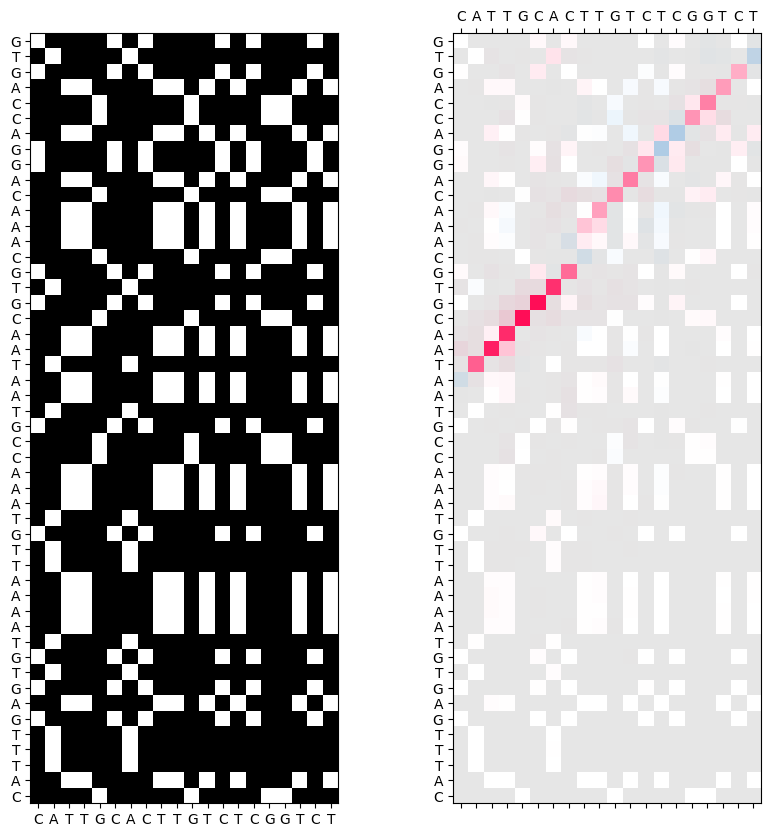

In [42]:
from shap.plots.colors import red_transparent_blue

fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(data[0,:,:,0], cmap='gray')
ax[0].set_xticks(range(len(miRNA)))
ax[0].set_xticklabels(miRNA)
ax[0].set_yticks(range(len(gene)))
ax[0].set_yticklabels(gene)

pos_shap = attribution
abs_vals = np.stack(np.abs(pos_shap.sum(-1)), 0).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
ax[1].imshow(data[0,:,:,0], alpha=0.1, cmap='gray')
ax[1].matshow(pos_shap[0,:,:,0], cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
ax[1].set_xticks(range(len(miRNA)))
ax[1].set_xticklabels(miRNA)
ax[1].set_yticks(range(len(gene)))
ax[1].set_yticklabels(gene)

plt.show();

In [53]:
from deepexperiment.alignment import Attrament

attrament = Attrament()
align_x, align_s, align_y = attrament(gene, miRNA[::-1], attribution[0,:,:,0])


In [51]:
print(" ".join(align_x))
print(" ".join(align_y))

C A T T T G A G T G T A A A A T T G T A A A C C G T A A T A A C G T G C A A A C A G G A C C A G T G
- - - - - - - - - - - - - - - - - - - - - - - - - - - C A T T G C A C - - T T G T C T C G G T C T -


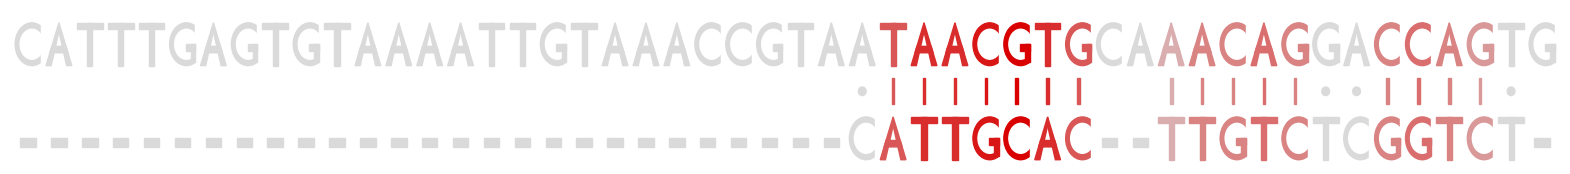

In [54]:
from deepexperiment.visualization import plot_alignment

plot_alignment(align_x, align_s, align_y)